In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
from collections import Counter
from tensorflow.keras.mixed_precision import set_global_policy, Policy
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from collections import defaultdict
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import ResNet50
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow as tfs
from tensorflow.keras.preprocessing import image
import tensorflow.keras.mixed_precision as mixed_precision
import matplotlib.pyplot as plt
import os
import random
import tensorflow_datasets as tfds
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2

In [ ]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
dataset, info = tfds.load('food101', with_info=True, as_supervised=True, split=['train', 'validation'])
train_dataset, test_dataset = dataset

In [ ]:
unique_labels = info.features['label'].names
print(f"Unique labels ({len(unique_labels)}): {unique_labels}")

Unique labels (101): ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 

In [ ]:
train_label_counts = {}

for image, label in train_dataset:
    label_name = unique_labels[label.numpy()]
    if label_name not in train_label_counts:
        train_label_counts[label_name] = 0
    train_label_counts[label_name] += 1

print("Number of items in each class in the training set:")
for label, count in train_label_counts.items():
    print(f"{label}: {count}")

Number of items in each class in the training set:
huevos_rancheros: 750
pizza: 750
chocolate_cake: 750
miso_soup: 750
bruschetta: 750
pad_thai: 750
spaghetti_bolognese: 750
waffles: 750
hamburger: 750
panna_cotta: 750
edamame: 750
filet_mignon: 750
chicken_quesadilla: 750
beef_tartare: 750
pork_chop: 750
caesar_salad: 750
tacos: 750
chicken_curry: 750
lasagna: 750
pulled_pork_sandwich: 750
chocolate_mousse: 750
fried_calamari: 750
baklava: 750
spring_rolls: 750
bread_pudding: 750
greek_salad: 750
churros: 750
risotto: 750
fried_rice: 750
eggs_benedict: 750
lobster_roll_sandwich: 750
omelette: 750
deviled_eggs: 750
prime_rib: 750
garlic_bread: 750
shrimp_and_grits: 750
clam_chowder: 750
cup_cakes: 750
breakfast_burrito: 750
french_onion_soup: 750
beef_carpaccio: 750
hummus: 750
oysters: 750
apple_pie: 750
scallops: 750
cannoli: 750
grilled_cheese_sandwich: 750
french_toast: 750
samosa: 750
ice_cream: 750
red_velvet_cake: 750
carrot_cake: 750
gyoza: 750
croque_madame: 750
peking_duck: 7

In [ ]:
test_label_counts = {}

for image, label in test_dataset:
    label_name = unique_labels[label.numpy()]
    if label_name not in test_label_counts:
        test_label_counts[label_name] = 0
    test_label_counts[label_name] += 1

print("Number of items in each class in the test set:")
for label, count in test_label_counts.items():
    print(f"{label}: {count}")

In [ ]:
train_count = sum(train_label_counts.values())
test_count = sum(test_label_counts.values())

print(f"\nNumber of items in the training set: {train_count}")
print(f"Number of items in the test set: {test_count}")

In [ ]:
def visualize_one_image_from_each_class(dataset, label_list):
    max_classes = 101
    visualized_labels = set()

    plt.figure(figsize=(15, 15))

    for image, label in dataset:
        label_name = label_list[label.numpy()]
        if label_name not in visualized_labels:
            plt.subplot(10, 10, len(visualized_labels) + 1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(label_name)
            plt.axis('off')
            visualized_labels.add(label_name)

        if len(visualized_labels) == min(len(label_list), max_classes):
            break

    plt.tight_layout()
    plt.show()

visualize_one_image_from_each_class(train_dataset, unique_labels)


This cell output is too large and can only be displayed while logged in.


In [ ]:
# Define preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224 for EfficientNetV2B0
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)  # Preprocess for EfficientNetV2B0
    return image, label

# Apply preprocessing to datasets
train_dataset = train_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

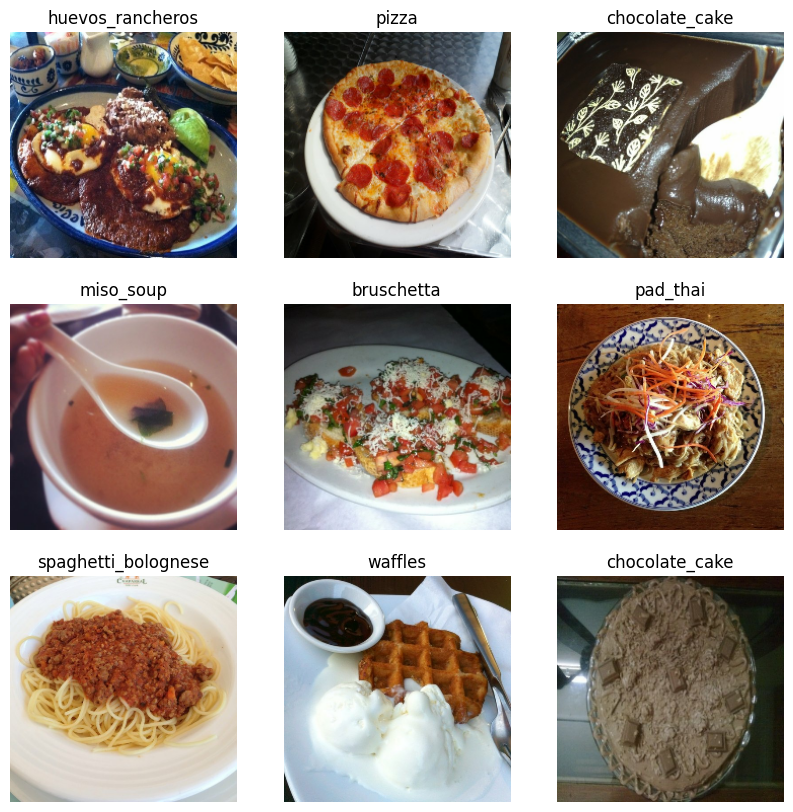

In [ ]:
def show_first_preprocessed_images(dataset, num_images=9):
    # Get the first batch of images and labels
    images, labels = next(iter(dataset.take(1)))

    # Select the first `num_images` images and labels
    selected_images = images[:num_images]
    selected_labels = labels[:num_images]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(selected_images[i].numpy().astype("uint8"))
        plt.title(unique_labels[selected_labels[i].numpy()])
        plt.axis('off')

    plt.show()

show_first_preprocessed_images(train_dataset)

In [ ]:
for images, labels in train_dataset.take(1):
    print(images.shape)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)
callbacks = [checkpoint_cb, early_stopping_cb]

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

In [ ]:
model = Sequential([
    EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224, 224, 3)),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(101, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=callbacks
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step
Precision: 0.7666
Recall: 0.7579
F1-Score: 0.7562


In [ ]:
class_report = classification_report(y_true, y_pred_classes, target_names=unique_labels)

print("Classification Report:")
print(class_report)

Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.62      0.36      0.45       250
         baby_back_ribs       0.77      0.74      0.75       250
                baklava       0.80      0.86      0.83       250
         beef_carpaccio       0.65      0.86      0.74       250
           beef_tartare       0.66      0.77      0.71       250
             beet_salad       0.56      0.73      0.64       250
               beignets       0.80      0.85      0.83       250
               bibimbap       0.86      0.93      0.89       250
          bread_pudding       0.54      0.57      0.55       250
      breakfast_burrito       0.77      0.48      0.59       250
             bruschetta       0.64      0.68      0.66       250
           caesar_salad       0.74      0.85      0.79       250
                cannoli       0.93      0.70      0.80       250
          caprese_salad       0.81      0.74      0.78       250
 

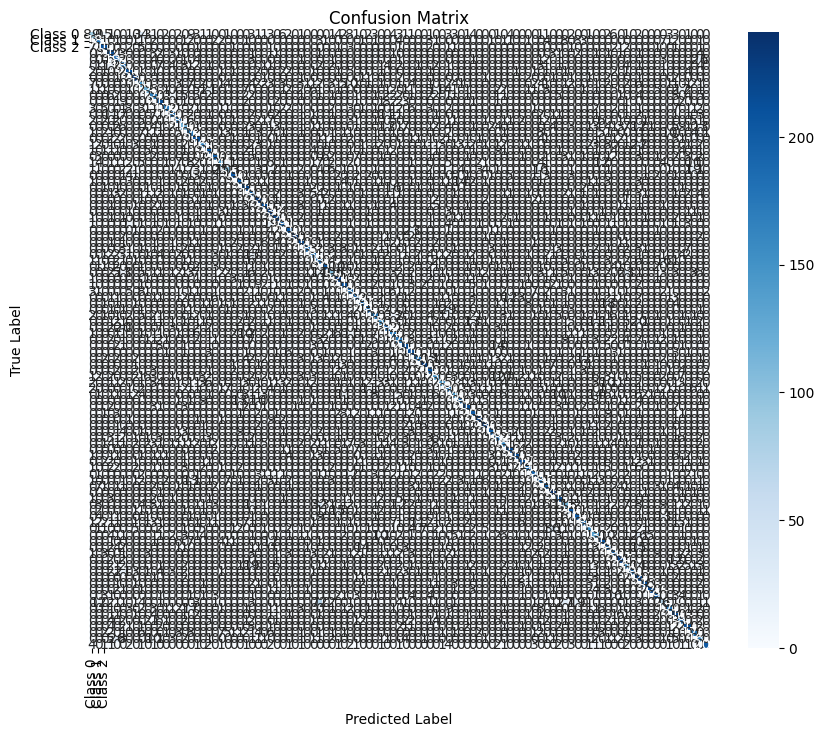

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

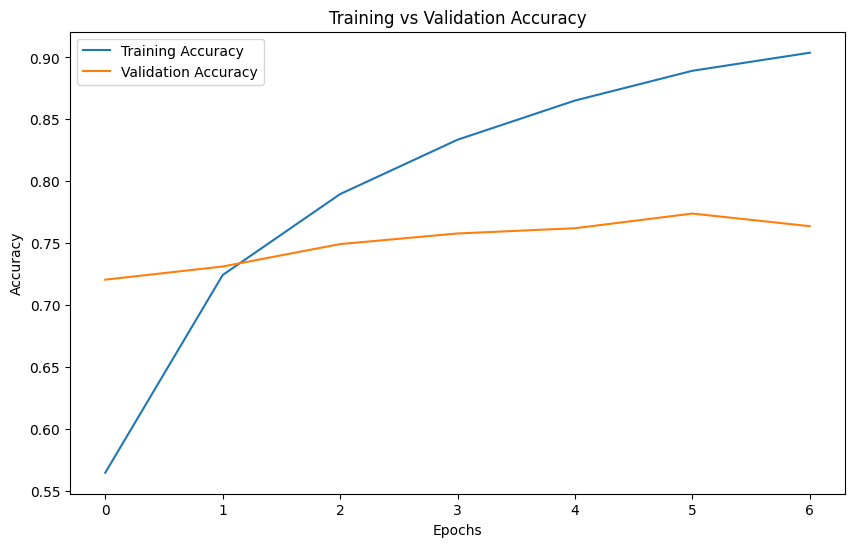

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

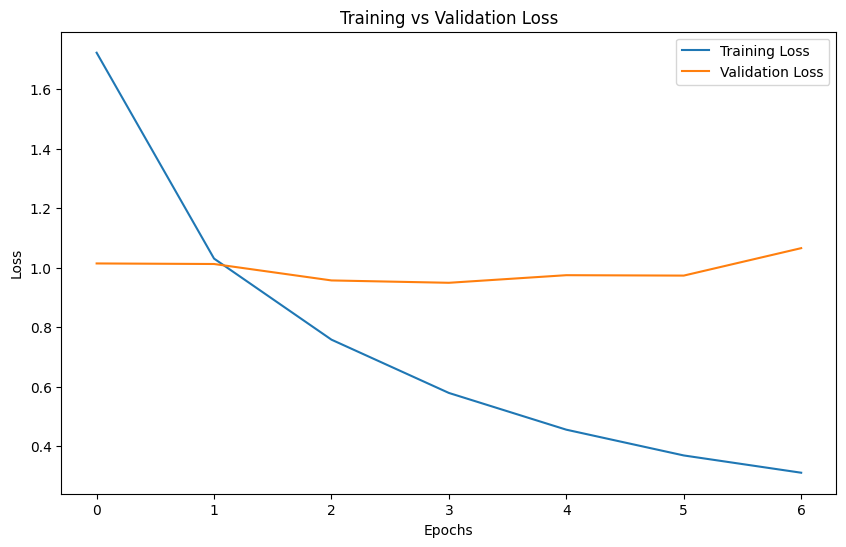

In [ ]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_dataset, test_dataset = dataset

def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_dataset = train_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
checkpoint_cb = ModelCheckpoint("best_resnet50_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)
callbacks = [checkpoint_cb, early_stopping_cb]

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load ResNet50 model with pre-trained weights and exclude the top layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Build a custom model on top of ResNet50
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(101, activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False
 # Unfreeze the last 10 layers
for layer in base_model.layers[-10:]:
        layer.trainable = True

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 454s 180ms/step - accuracy: 0.4549 - loss: 2.3031 - val_accuracy: 0.6760 - val_loss: 1.2048
Epoch 2/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 349s 147ms/step - accuracy: 0.6926 - loss: 1.1615 - val_accuracy: 0.6872 - val_loss: 1.2059
Epoch 3/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 351s 148ms/step - accuracy: 0.7943 - loss: 0.7595 - val_accuracy: 0.6745 - val_loss: 1.3742
Epoch 4/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 381s 148ms/step - accuracy: 0.8777 - loss: 0.4388 - val_accuracy: 0.6736 - val_loss: 1.5831
Epoch 5/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 379s 147ms/step - accuracy: 0.9225 - loss: 0.2598 - val_accuracy: 0.6718 - val_loss: 1.7700
Epoch 6/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 444s 173ms/step - accuracy: 0.9413 - loss: 0.1881 - val_accuracy: 0.6896 - val_loss: 1.7063
Epoch 7/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 348s 147ms/step - accuracy: 0.9554 - loss: 0.1424 - val_accuracy: 0.6844 - val_loss: 1.8350
Epoch 8/15


In [ ]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=15,
                    callbacks=callbacks)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

790/790 ━━━━━━━━━━━━━━━━━━━━ 87s 103ms/step
Precision: 0.7289
Recall: 0.7101
F1-Score: 0.7094


In [ ]:
class_report = classification_report(y_true, y_pred_classes, target_names=unique_labels)

print("Classification Report:")
print(class_report)

Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.44      0.58      0.50       250
         baby_back_ribs       0.63      0.78      0.70       250
                baklava       0.66      0.81      0.73       250
         beef_carpaccio       0.72      0.80      0.76       250
           beef_tartare       0.73      0.55      0.63       250
             beet_salad       0.58      0.59      0.59       250
               beignets       0.66      0.88      0.75       250
               bibimbap       0.92      0.80      0.85       250
          bread_pudding       0.62      0.36      0.46       250
      breakfast_burrito       0.78      0.55      0.64       250
             bruschetta       0.61      0.63      0.62       250
           caesar_salad       0.64      0.84      0.73       250
                cannoli       0.86      0.69      0.77       250
          caprese_salad       0.68      0.75      0.71       250
 

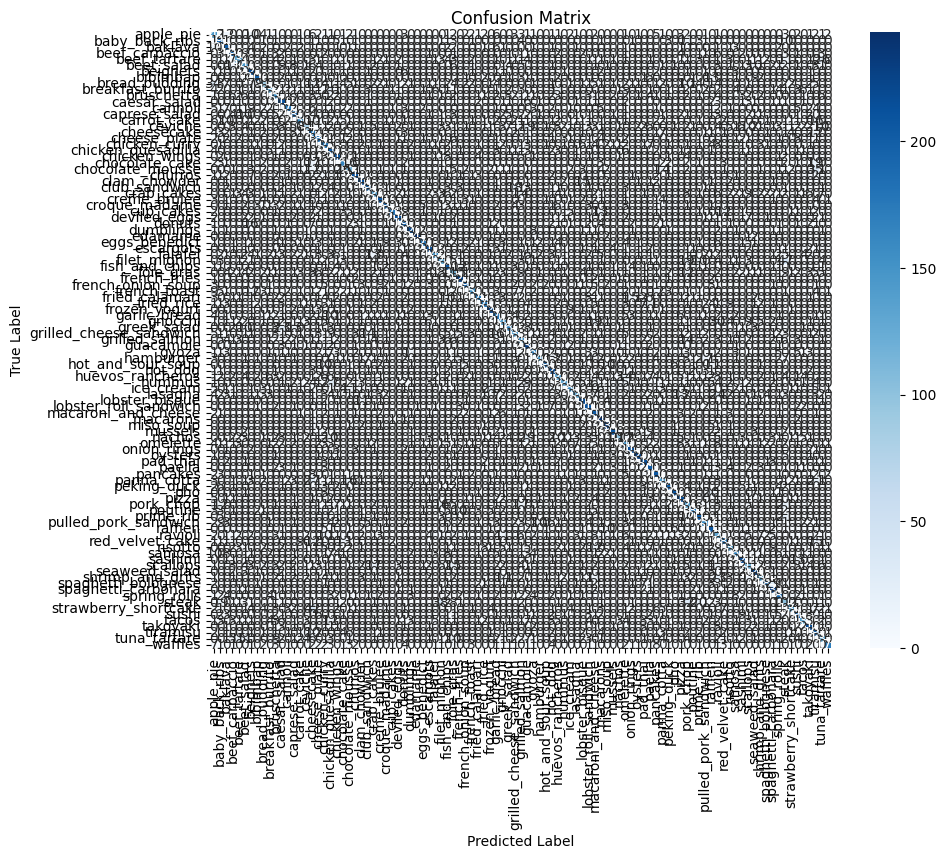

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

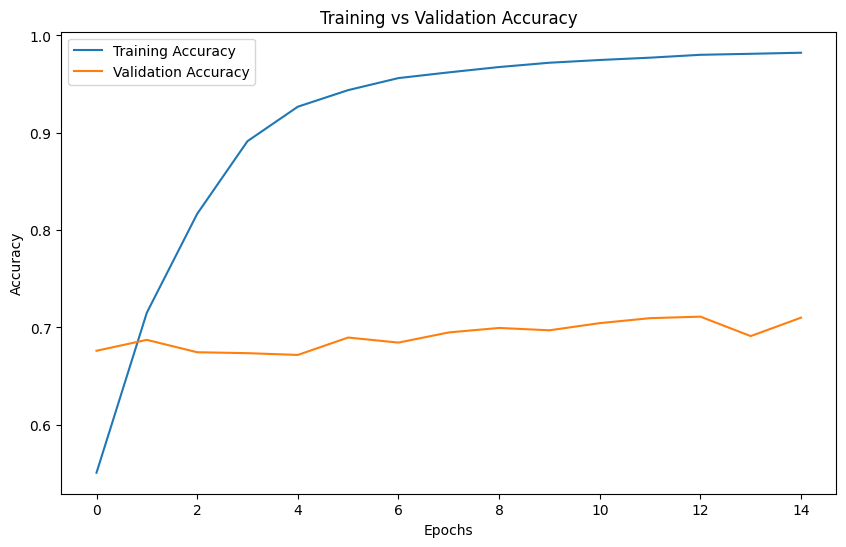

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

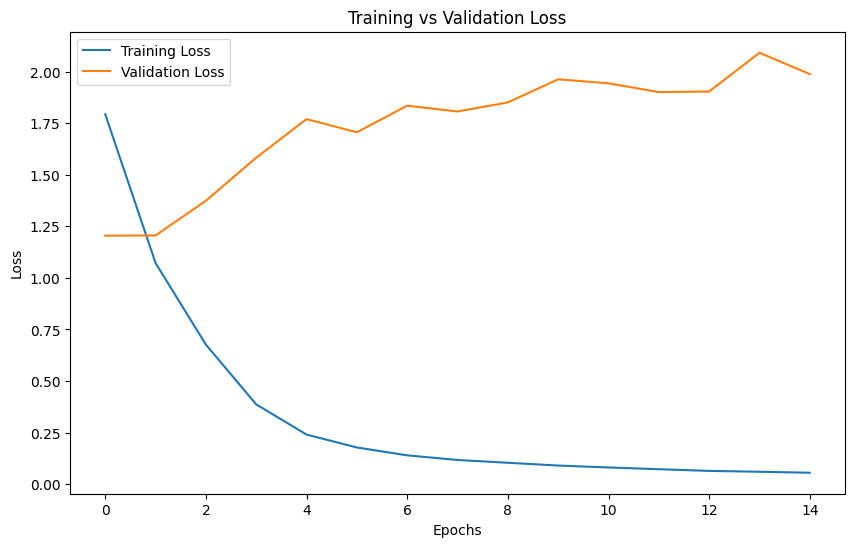

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()